In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import *
π = pi
import matplotlib.animation as mplanim 
plt.rc('animation', html='jshtml')
from typing import Callable
from scipy import integrate
from scipy import optimize
import scipy.special as ss
from mpl_toolkits.axes_grid1 import AxesGrid
from tqdm.notebook import tqdm
import os
#%config InlineBackend.figure_formats = ['svg']
plt.rcParams['mpl_toolkits.legacy_colorbar'] = False

# General functions

In [203]:
def ωn (β:float, n:int) -> float:
    return (2*n+1)*π / β

def greenmatsubara_time_to_freq (β:float, dτ:float, Gτ:np.array) -> Callable[[int],complex]:
    τ = np.arange(0, β+1e-10, dτ)
    # between 0 and β integrate G(τ) exp(i.ωn.τ)
    f = lambda n: dτ * np.sum( np.exp(1j*ωn(β,n)*τ) * Gτ )
    return np.vectorize(f)

def greenmatsubara_freq_to_time_sing (β:float, iωn:np.array, Giωn_sing:np.array, halfiωn=False) -> Callable[[float],float]:
    # if halfiωn=False, Giωn should have an even size 2N, corresponding to n's in [-n,n[ (eg. [-1,0], [-2,-1,0,1]...)
    #                   ( n = np.arange(-len(Giωn_sing)//2, len(Giωn_sing)//2) )
    # if halfiωn=True, Giωn should have a size N, corresponding to n's in [0,N[
    if halfiωn:
        f = lambda τ: 2/β * np.sum( np.real( np.exp(-iωn*τ) * Giωn_sing ) ) + (-1/2 if τ>=0 else +1/2)
    else:
        f = lambda τ: 1/β * np.sum(          np.exp(-iωn*τ) * Giωn_sing )   + (-1/2 if τ>=0 else +1/2)
    return np.vectorize(f)

def greenfunc_forget_negfreq (Giωn, iωn=None, n=None):
    N = len(Giωn)//2
    if n is None:
        if iωn is None:
            return Giωn[N:]
        else:
            return Giωn[N:], iωn[N:]
    else:
        return Giωn[N:], iωn[N:], n[N:]

def greenfunc_extend_negfreq (Giωn):
    N = len(Giωn)
    Giωn_new = np.zeros(2*N, dtype=np.complex128)
    Giωn_new[N:] = Giωn
    Giωn_new[:N] = np.flip( np.real(Giωn) -1j * np.imag(Giωn) )
    n = np.arange(-N,N)
    iωn = 1j*ωn(β,n)
    return Giωn_new, iωn, n

In [3]:
def Giωn_at (β, iωn, U):
    return 1/2 / ( iωn - U/2 ) + 1/2 / ( iωn + U/2 )

def Gτ_at (β, τ, U):
    return -1/2 * np.exp(-τ*U/2) / ( np.exp(-β*U/2) + 1 ) -1/2 * np.exp(+τ*U/2) / ( np.exp(+β*U/2) + 1 )

def G0_loc_iωn (latt_hilbert, iωn, µ):
    return latt_hilbert(iωn+µ)

In [14]:
def plot_Gτ_without_discont (Gτ_f, τ, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    pos = np.where(τ >= 0)[0][0]
    Gτ = np.insert(np.real(Gτ_f(τ)), pos, np.nan)
    τ = np.insert(τ, pos, np.nan)
    plt.plot(τ,Gτ,**kwargs)

In [175]:
# t = 1 implicitely here, for the Bethe lattice

def latt_Bethe_DoS (ϵ:float) -> float:
    return 1/(2*π) * np.sqrt(4-ϵ**2)

def latt_Bethe_hilbert (z:complex) -> complex:
    s = np.sign(np.imag(z))
    return ( z - 1j*s*np.sqrt(4 - z**2) ) /2

def latt_Bethe_R (η:complex) -> complex:
#    if np.any(np.abs(η)>1):
#        raise ValueError("the reciprocal Hilbert transform for the Bethe lattice is defined only on {|z|<1}")
    return η + 1/η

In [5]:
# eq (self-consistent-eq-reciproc-Hilbert-fromcavity)

def imp_Gbath_from_Gloc (R:Callable[[complex],complex], iωn:np.array, Gloc_iωn:np.array, µ:float) -> np.array:
    return 1 /( iωn + µ + 1/Gloc_iωn - R(Gloc_iωn) )

# IPT DMFT loop

In [271]:
def impurity_solver_IPT (β:float, U:float, iωn:np.array, Gbath_iωn:np.array, dτ=1e-3, halfiωn=False) -> Callable[[int],complex]:
    # Gbath_iωn should have an even size 2N, corresponding to n's in [-N,N[ (eg. [-1,0], [-2,-1,0,1]...)
    Gbath_shift_iωn = 1/( 1/Gbath_iωn - U/2 )
    τ = np.arange(0, β+1e-10, dτ)
    Gbath_shift_τ = greenmatsubara_freq_to_time_sing(β, iωn, Gbath_shift_iωn-1/iωn, halfiωn)
    Gbath_shift_τ = Gbath_shift_τ(τ)
                                   # between 0 and β integrate G(τ)^3 exp(i.ωn.τ)
    f = lambda n: U/2 + U**2 * dτ * np.sum( np.exp(1j*ωn(β,n)*τ) * Gbath_shift_τ**3 )
    return np.vectorize(f)#, τ, Gbath_shift_τ

In [303]:
def plot_Giωn (ax, G_iωn, name="G", twinx_im=False):
    n = np.arange(-len(G_iωn)//2,len(G_iωn)//2)
    if twinx_im:
        ax_im = ax.twinx()
    else:
        ax_im = ax
    ax_im.plot(n, np.imag(G_iωn), '.--', lw=1, label='im. part', color='blue')
    ax.plot(n, np.real(G_iωn), '.--', lw=1, label='re. part', color='orange')
    ax.set_xlabel("$n$")
    ax.set_title("$"+name+r"(i\omega_n)$")
    ax.legend(loc='upper left')
    if twinx_im:
        ax_im.legend(loc='upper right')
        m = 1.5 * np.max(np.abs(np.real(G_iωn)))
        ax.set_ylim((-m,+m))
        
def DMFT_loop_Gloc (β, U, latt_R, Gloc_iωn_0, conv_thresh=1e-5, γ=0.9, callback=None, internal_halfiωn=False, discard_real_part=0, IPT_dτ=1e-3):
    µ = U/2
    n = np.arange(-len(Gloc_iωn_0)//2,len(Gloc_iωn_0)//2)
    iωn = 1j*ωn(β,n)
    Gloc_iωn = Gloc_iωn_0
    if internal_halfiωn:
        Gloc_iωn, iωn, n = greenfunc_forget_negfreq(Gloc_iωn_0, iωn, n)

    maxit = max(100,int(β))
    for it in range(maxit):

        # DMFT loop
        Gbath_iωn = imp_Gbath_from_Gloc (latt_Bethe_R, iωn, Gloc_iωn, µ)
        Σloc_iωn = impurity_solver_IPT (β, U, iωn, Gbath_iωn, dτ=IPT_dτ, halfiωn=internal_halfiωn)
        Σloc_iωn = Σloc_iωn(n)
        Gloc_iωn_new = latt_Bethe_hilbert( iωn + µ - Σloc_iωn )
        # or : Gloc_iωn_new = 1 / ( 1/Gbath_iωn - Σloc_iωn )
        Gloc_iωn_new -= discard_real_part * np.real(Gloc_iωn_new)

        norm1_diff = np.linalg.norm(Gloc_iωn-Gloc_iωn_new, ord=1)
        if callback is not None:
            callback(it,iωn,Σloc_iωn,Gloc_iωn_new,norm1_diff)
        if norm1_diff < conv_thresh:
            Gloc_iωn = Gloc_iωn_new
            break
        Gloc_iωn = (1-γ) * Gloc_iωn + γ * Gloc_iωn_new
    
    if it == maxit-1:
        raise RuntimeError("DMFT loop did not converge")
    if internal_halfiωn:
        return µ, greenfunc_extend_negfreq(Gloc_iωn)[0], greenfunc_extend_negfreq(Σloc_iωn)[0], greenfunc_extend_negfreq(Gbath_iωn)[0]
    else:
        return µ, Gloc_iωn, Σloc_iωn, Gbath_iωn

In [136]:
def cb_print_delta (it, iωn, Σloc_iωn, Gloc_iωn_new, norm1_diff):
    n = len(iωn)//2
    deriv0 = (Σloc_iωn[n+1] - Σloc_iωn[n]).imag / (iωn[n+1] - iωn[n]).imag
    print("L1delta",norm1_diff,"; deriv0 ",deriv0)

L1delta 1.1780520161597252e-06
L1delta 5.281172268910284e-07
L1delta 2.4644664732911825e-07
L1delta 1.1412529008110461e-07
L1delta 5.2976898099257874e-08
L1delta 2.457192720649315e-08
L1delta 1.1400387772697584e-08
L1delta 5.288839392478262e-09
L1delta 2.4538402247642477e-09
L1delta 1.1385315277362418e-09
L1delta 5.283398319538835e-10


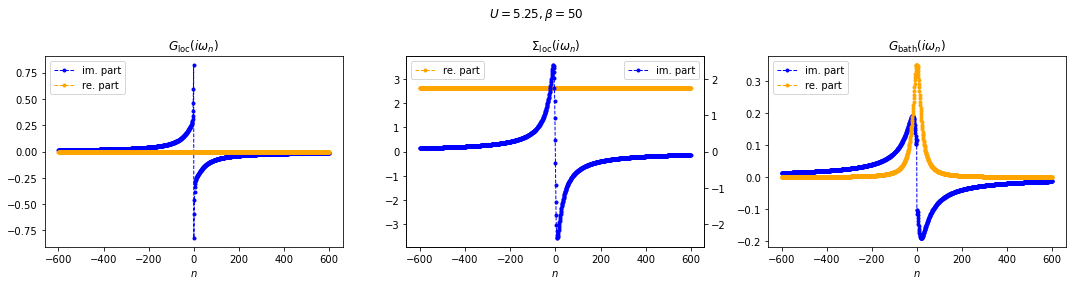

In [465]:
β = 50
U = 5.25
iωn = 1j*ωn(β,np.arange(-600,+600))
Gloc_iωn_0 = G0_loc_iωn(latt_Bethe_hilbert, iωn, 0)     # metallic initial condition
#Gloc_iωn_0 = Giωn_at(β, iωn, U)        # atomic limit initial condition
Gloc_iωn_0 = Gloc_iωn_base

def cb_reg_real_part (it, iωn, Σloc_iωn, Gloc_iωn_new, norm1_diff):
    print("L1delta",norm1_diff)
    return
  #  fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(16,5))
    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,5))
    fig.suptitle(r"Init. increasing $U$, $U={}, \beta={}$. DMFT loop iter {}".format(U,β,it))
    plot_Giωn(ax1, greenfunc_extend_negfreq(Σloc_iωn)[0], "\Sigma_\operatorname{loc}", twinx_im=True)
    ax1.set_ylim((-4,4))
    plot_Giωn(ax2, greenfunc_extend_negfreq(Gloc_iωn_new)[0], "G_\operatorname{loc}")
    ax2.set_ylim((-1.1,1.1))
    fig.tight_layout()
    plt.savefig("anim/{}.png".format(it), bbox_inches='tight')
    plt.show()

µ, Gloc_iωn, Σloc_iωn, Gbath_iωn = DMFT_loop_Gloc (β, U, latt_Bethe_R, Gloc_iωn_0, γ=1.2, conv_thresh=1e-9, discard_real_part=1, callback=cb_reg_real_part, IPT_dτ=1e-4, internal_halfiωn=True)

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15,4))
plot_Giωn(ax1, Gloc_iωn, "G_\operatorname{loc}")
plot_Giωn(ax2, Σloc_iωn, "\Sigma_\operatorname{loc}", twinx_im=True)
plot_Giωn(ax3, Gbath_iωn, "G_\operatorname{bath}")
fig.suptitle(r"$U={}, \beta={}$".format(U,β))
fig.tight_layout()

In [464]:
Gloc_iωn_base = Gloc_iωn

In [466]:
tau = np.linspace(0,β,10000)
Gtau_ref = greenmatsubara_freq_to_time_sing (β, iωn, Gloc_iωn-1/iωn)
Gtau_ref = Gtau_ref(tau)

In [441]:
Gloc_iωn_s = []
Σloc_iωn_s = []
Zs = []
#Dtau = [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
Dtau = [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
for dtau in Dtau:
    print(dtau)
    µ, Gloc_iωn, Σloc_iωn, _ = DMFT_loop_Gloc (β, U, latt_Bethe_R, Gloc_iωn_base, γ=1.1, conv_thresh=1e-8, discard_real_part=1, callback=cb_print_delta, IPT_dτ=dtau, internal_halfiωn=True)
    Gloc_iωn_s.append(Gloc_iωn)
    Σloc_iωn_s.append(Σloc_iωn)
    Zs.append(quasipart_z (iωn, Σloc_iωn))

1
L1delta 4.976790217485469 ; deriv0  -4.1833080371437505
L1delta 0.8320747342297989 ; deriv0  -3.7903298270116075
L1delta 0.1689688389556227 ; deriv0  -3.5609461917609555
L1delta 0.10418938489778429 ; deriv0  -3.4405003964580567
L1delta 0.05168982369110673 ; deriv0  -3.3789321475375003
L1delta 0.026762569262874025 ; deriv0  -3.347632831435517
L1delta 0.013656243673024204 ; deriv0  -3.3317345847020157
L1delta 0.006961462218753215 ; deriv0  -3.3236593320659082
L1delta 0.003542053174171278 ; deriv0  -3.3195573408999226
L1delta 0.0018009500377519465 ; deriv0  -3.3174735394046606
L1delta 0.0009153113922597093 ; deriv0  -3.3164149416060282
L1delta 0.00046510286556510766 ; deriv0  -3.3158771518944654
L1delta 0.00023631105959973087 ; deriv0  -3.3156039413072778
L1delta 0.00012005944111721789 ; deriv0  -3.315465142938272
L1delta 6.099538662319298e-05 ; deriv0  -3.315394629463174
L1delta 3.098787335747977e-05 ; deriv0  -3.315358806596194
L1delta 1.574285760015323e-05 ; deriv0  -3.31534060754279

In [467]:
Dtau = [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
L1deltaGloc_100 = []
for i in range(len(Dtau)):
    L1deltaGloc_100.append(np.linalg.norm(Gloc_iωn_s_100[i]-Gloc_iωn_s_100[-1],ord=1))
L1deltaGloctau_100 = []
for i in tqdm(range(len(Dtau))):
    iωn = 1j*ωn(β,np.arange(-100,+100))
    Gtau = greenmatsubara_freq_to_time_sing (β, iωn, Gloc_iωn_s_100[i]-1/iωn)
    Gtau = Gtau(tau)
    L1deltaGloctau_100.append(np.linalg.norm(Gtau-Gtau_ref,ord=1)/len(tau))

In [468]:
Dtau = [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
L1deltaGloc_200 = []
for i in range(len(Dtau)):
    L1deltaGloc_200.append(np.linalg.norm(Gloc_iωn_s_200[i]-Gloc_iωn_s_200[-1],ord=1))
L1deltaGloctau_200 = []
for i in tqdm(range(len(Dtau))):
    iωn = 1j*ωn(β,np.arange(-200,+200))
    Gtau = greenmatsubara_freq_to_time_sing (β, iωn, Gloc_iωn_s_200[i]-1/iωn)
    Gtau = Gtau(tau)
    L1deltaGloctau_200.append(np.linalg.norm(Gtau-Gtau_ref,ord=1)/len(tau))

In [469]:
Dtau = [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
L1deltaGloc_300 = []
for i in range(len(Dtau)):
    L1deltaGloc_300.append(np.linalg.norm(Gloc_iωn_s_300[i]-Gloc_iωn_s_300[-1],ord=1))
L1deltaGloctau_300 = []
for i in tqdm(range(len(Dtau))):
    iωn = 1j*ωn(β,np.arange(-300,+300))
    Gtau = greenmatsubara_freq_to_time_sing (β, iωn, Gloc_iωn_s_300[i]-1/iωn)
    Gtau = Gtau(tau)
    L1deltaGloctau_300.append(np.linalg.norm(Gtau-Gtau_ref,ord=1)/len(tau))

In [470]:
Dtau = [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
L1deltaGloc_400 = []
for i in range(len(Dtau)):
    L1deltaGloc_400.append(np.linalg.norm(Gloc_iωn_s_400[i]-Gloc_iωn_s_400[-1],ord=1))
L1deltaGloctau_400 = []
for i in tqdm(range(len(Dtau))):
    iωn = 1j*ωn(β,np.arange(-400,+400))
    Gtau = greenmatsubara_freq_to_time_sing (β, iωn, Gloc_iωn_s_400[i]-1/iωn)
    Gtau = Gtau(tau)
    L1deltaGloctau_400.append(np.linalg.norm(Gtau-Gtau_ref,ord=1)/len(tau))

In [471]:
Dtau = [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
L1deltaGloc_500 = []
for i in range(len(Dtau)):
    L1deltaGloc_500.append(np.linalg.norm(Gloc_iωn_s_500[i]-Gloc_iωn_s_500[-1],ord=1))
L1deltaGloctau_500 = []
for i in tqdm(range(len(Dtau))):
    iωn = 1j*ωn(β,np.arange(-500,+500))
    Gtau = greenmatsubara_freq_to_time_sing (β, iωn, Gloc_iωn_s_500[i]-1/iωn)
    Gtau = Gtau(tau)
    L1deltaGloctau_500.append(np.linalg.norm(Gtau-Gtau_ref,ord=1)/len(tau))

In [449]:
Zs_500 = Zs
Gloc_iωn_s_500 = Gloc_iωn_s
Σloc_iωn_s_500 = Σloc_iωn_s

In [483]:
Dtau = [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
np.savez("n500.npz", Gloc_s=Gloc_iωn_s_500, Sigmaloc_s=Σloc_iωn_s_500, dtau_s=Dtau, iwn=1j*ωn(β,np.arange(-500,+500)))

In [487]:
Dtau = [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
np.savez("n100.npz", Gloc_s=Gloc_iωn_s_100, Z_s=Zs_100, dtau_s=Dtau, iwn=1j*ωn(β,np.arange(-100,+100)))

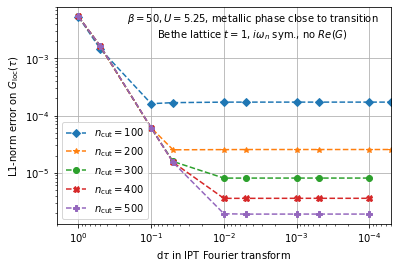

In [565]:
Dtau = [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
plt.plot(Dtau, L1deltaGloctau_100, 'D--', label="$n_\operatorname{cut}=100$")
Dtau = [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
plt.plot(Dtau, L1deltaGloctau_200, '*--', label="$n_\operatorname{cut}=200$")
Dtau = [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
plt.plot(Dtau, L1deltaGloctau_300, 'o--', label="$n_\operatorname{cut}=300$")
plt.plot(Dtau, L1deltaGloctau_400, 'X--', label="$n_\operatorname{cut}=400$")
Dtau = [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
plt.plot(Dtau, L1deltaGloctau_500, 'P--', label="$n_\operatorname{cut}=500$")
plt.xscale('log')
#plt.yscale('symlog', linthresh=1e-7)
plt.yscale('log')
#plt.ylim((1e-8,20))
plt.xlim((2,5e-5))
plt.grid()
plt.xlabel(r"d$\tau$ in IPT Fourier transform")
plt.ylabel(r"L1-norm error on $G_\operatorname{loc}(\tau)$")
plt.legend(loc='lower left')
plt.text(4e-3, 2.3e-3, r"$\beta={}, U={}$".format(β,U)+", metallic phase close to transition\nBethe lattice $t=1$, $i\omega_n$ sym., no $Re(G)$", ha='center')
plt.savefig("Gloc-vs-Glocref.pdf", bbox_inches='tight')

In [495]:
z_ref = quasipart_z (iωn, Σloc_iωn)

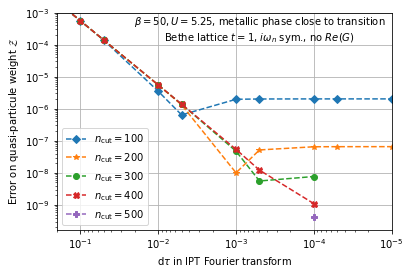

In [566]:
Dtau = [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
plt.plot(Dtau, np.abs(Zs_100-z_ref), 'D--', label="$n_\operatorname{cut}=100$")
Dtau = [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
plt.plot(Dtau, np.abs(Zs_200-z_ref), '*--', label="$n_\operatorname{cut}=200$")
Dtau = [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
plt.plot(Dtau, np.abs(Zs_300-z_ref), 'o--', label="$n_\operatorname{cut}=300$")
plt.plot(Dtau, np.abs(Zs_400-z_ref), 'X--', label="$n_\operatorname{cut}=400$")
Dtau = [1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
plt.plot(Dtau, np.abs(Zs_500-z_ref), 'P--', label="$n_\operatorname{cut}=500$")
plt.xscale('log')
plt.xlim((0.2,1e-5))
plt.yscale('log')
plt.ylim((None,1e-3))
plt.grid()
plt.xlabel(r"d$\tau$ in IPT Fourier transform")
plt.ylabel(r"Error on quasi-particule weight $\mathcal{Z}$")
plt.text(5e-4, 1.35e-4, r"$\beta={}, U={}$".format(β,U)+", metallic phase close to transition\nBethe lattice $t=1$, $i\omega_n$ sym., no $Re(G)$", ha='center')
plt.legend(loc='lower left')
plt.savefig("z-vs-zref.pdf", bbox_inches='tight')